<a href="https://colab.research.google.com/github/nudojacopo/thesis/blob/main/src/SYN/focus/tox_pol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
!git clone https://github.com/nudojacopo/thesis.git
from google.colab import drive
drive.mount('/content/drive')
root='/content/'
import sys
module_path = root+'thesis/src/SYN'
sys.path.append(module_path)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
!pip install powerlaw
from SYN_package.functions import *
from SYN_package.estimate_parameters import *
import json
from scipy import stats
import random
from scipy.stats import chi2
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import powerlaw
import warnings

Cloning into 'thesis'...
remote: Enumerating objects: 1787, done.
remote: Counting objects: 100% (514/514), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 1787 (delta 314), reused 474 (delta 293), pack-reused 1273
Receiving objects: 100% (1787/1787), 79.65 MiB | 14.62 MiB/s, done.
Resolving deltas: 100% (1135/1135), done.
Updating files: 100% (57/57), done.
Mounted at /content/drive


# Set up

In [ ]:
# Choose settings for the parameters part
estimate_parameters=True # to estimate parameters
name_parameters='params_dict_trial_fb_1015' # good for ZIE separated

n=500 # number of threads
h=100 # number of hours considered

## Prepare Data

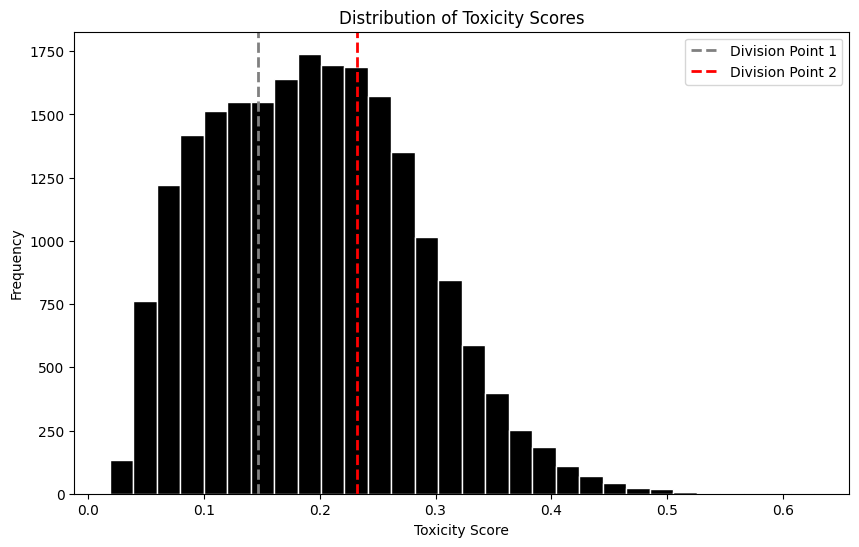

  0%|          | 0/3 [00:00<?, ?it/s]/content/thesis/src/SYN/SYN_package/estimate_parameters.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_comments_by_user_in_thread'].copy()
 33%|███▎      | 1/3 [00:22<00:44, 22.17s/it]/content/thesis/src/SYN/SYN_package/estimate_parameters.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_comment']=df['sequential_number_of_comment_by_user_in_thread']==df['number_of_co

In [ ]:
fb=pd.read_csv('/content/drive/MyDrive/thesis/data/facebook/facebook_news_PRO.csv')
fb=filter_first_h(fb,h)

fb['year'] = pd.to_datetime(fb['thread_birth']).dt.year

fb['is_toxic']=fb['toxicity_score']>0.6
toxicity_share_distribution=fb.groupby(['post_id'])['toxicity_score'].mean().reset_index()


polite_post_ids=toxicity_share_distribution[toxicity_share_distribution['toxicity_score']<toxicity_share_distribution['toxicity_score'].quantile(0.1)]['post_id']

normal_post_ids = toxicity_share_distribution[
    (toxicity_share_distribution['toxicity_score'] < toxicity_share_distribution['toxicity_score'].quantile(0.55)) &
    (toxicity_share_distribution['toxicity_score'] > toxicity_share_distribution['toxicity_score'].quantile(0.45))
]['post_id']

toxic_post_ids=toxicity_share_distribution[toxicity_share_distribution['toxicity_score']>toxicity_share_distribution['toxicity_score'].quantile(0.9)]['post_id']


import matplotlib.pyplot as plt
import pandas as pd

# Esempio di dati (da sostituire con i tuoi dati effettivi)
# toxicity_share_distribution è il DataFrame, e 'toxicity_score' è la colonna di interesse
toxicity_scores = toxicity_share_distribution['toxicity_score']

# Creiamo l'istogramma
plt.figure(figsize=(10, 6))
plt.hist(toxicity_scores, bins=30, color='black', edgecolor='white')  # Modifica il numero di bins a seconda della distribuzione dei tuoi dati

# Trova i quantili per dividere in tre parti uguali
quantiles = toxicity_scores.quantile([0.33, 0.66])

# Disegna le linee verticali per dividere l'istogramma
plt.axvline(quantiles.iloc[0], color='gray', linestyle='--', linewidth=2, label='Division Point 1')
plt.axvline(quantiles.iloc[1], color='red', linestyle='--', linewidth=2, label='Division Point 2')

# Aggiungi legenda e etichette
plt.legend()
plt.xlabel('Toxicity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Toxicity Scores')

plt.show()


toxic=fb[fb['post_id'].isin(toxic_post_ids)]

toxic.groupby('post_id')['comment_id'].count().median()

polite=fb[fb['post_id'].isin(polite_post_ids)]

polite.groupby('post_id')['comment_id'].count().median()

normal=fb[fb['post_id'].isin(normal_post_ids)]

names=['toxic','normal','polite']
datas=[toxic,normal,polite]


params_dict = process_social_platform(names, datas)
file_path = '/content/drive/MyDrive/thesis/data/parameters/'+'tox'+'.json'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'w') as file:
    json.dump(params_dict, file)

df = pd.DataFrame.from_dict(params_dict, orient='index')
df


time_intervals = np.arange(0, 1, 0.05)

all_dfs = []
for i, df in enumerate(datas):
    social = names[i]
    parameters = params_dict[social]
    datas_processed_s=[]
    datas_processed_o=[]
    names_processed=[]

    simulated_t, observed_t = simulate_data(df, parameters, activate_tqdm=True, num_threads=n)# peensaree a come limitar i valori dell funzionee IAT senza crear break infiniti
    globals()[f"{social}s_M1"] = simulated_t
    globals()[f"{social}o_M1"] = observed_t
    simulated_t_ECDF = calculate_ECDF(simulated_t, time_intervals)
    simulated_t_ECDF['Platform'] = social
    simulated_t_ECDF['Style'] = 'Simulated'

    observed_t_ECDF = calculate_ECDF(observed_t, time_intervals)
    observed_t_ECDF['Platform'] = social
    observed_t_ECDF['Style'] = 'Observed'

    df_platform = pd.concat([simulated_t_ECDF, observed_t_ECDF], ignore_index=True)
    all_dfs.append(df_platform)

df_all_M1 = pd.concat(all_dfs, ignore_index=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Assuming df_all_M1 is your DataFrame containing the data
# Filter and preprocess your data as needed
df_all = df_all_M1.copy()
df_all = df_all[df_all['Style'] == 'Observed']  # Assuming you want only the 'Observed' style
df_all['Log_Share'] = np.log(df_all['Share'])  # Compute logarithm of Share

# Define the styles for comparison and initialize an empty DataFrame for results
styles = ['polite', 'toxic', 'normal']
results = pd.DataFrame(index=styles, columns=styles)

# Perform KS test for each pairwise combination of styles
for i in range(len(styles)):
    for j in range(i, len(styles)):
        style1 = styles[i]
        style2 = styles[j]

        # Select data for the two styles
        data1 = df_all[df_all['Platform'] == style1]['Log_Share']
        data2 = df_all[df_all['Platform'] == style2]['Log_Share']

        # Perform KS test
        ks_statistic, p_value = ks_2samp(data1, data2)

        # Store p-value in the results DataFrame
        results.loc[style1, style2] = p_value
        results.loc[style2, style1] = p_value  # Since KS test is symmetric, store both ways

# Display the results table
print("KS Test Results:")
print(results)


In [116]:
df = pd.DataFrame.from_dict(params_dict, orient='index')
df

,gamma,a,b,loc,scale,alpha,lambda,a_IAT,b_IAT,af_IAT,bf_IAT
toxic,3.296141,0.518918,97.225434,0.001,13.583786,0.734687,0.965022,0.041340,2.264588,0.093240,1.856097
normal,3.381554,0.726242,789.583196,0.001,79.284120,0.737409,0.965255,0.037904,2.350947,0.087448,1.887702
polite,3.382801,0.586857,39.316349,0.001,8.822699,0.755962,0.969242,0.031439,2.210386,0.086335,1.939142


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


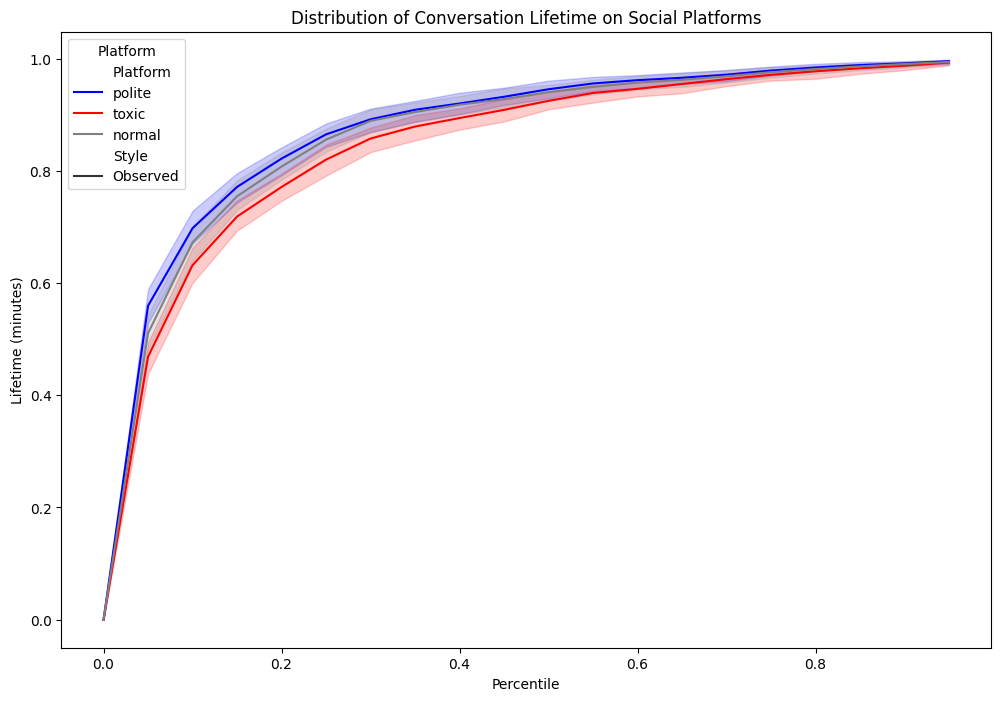

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_all_M1 is your DataFrame containing the data
df_all = df_all_M1.sort_values(by='Style')
df_all=df_all[df_all['Style']=='Observed']
df_all['Log_Share']=np.log(df_all['Share'])
# Define colors based on Style categories
palette = {'polite': 'blue', 'toxic': 'red', 'normal': 'grey'}

plt.figure(figsize=(12, 8))
sns.lineplot(data=df_all, x='Time Grid Value', y='Share', hue='Platform', style='Style', err_style='band', palette=palette, errorbar=('ci', 100))
plt.title('Distribution of Conversation Lifetime on Social Platforms')
plt.ylabel('Lifetime (minutes)')
plt.xlabel('Percentile')
plt.grid(False)
plt.legend(title='Platform')
plt.show()


In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Assuming df_all_M1 is your DataFrame containing the data
# Filter and preprocess your data as needed
df_all = df_all_M1.copy()
df_all = df_all[df_all['Style'] == 'Observed']  # Assuming you want only the 'Observed' style
df_all['Log_Share'] = np.log(df_all['Share'])  # Compute logarithm of Share

# Define the styles for comparison and initialize an empty DataFrame for results
styles = ['polite', 'toxic', 'normal']
results = pd.DataFrame(index=styles, columns=styles)

# Perform KS test for each pairwise combination of styles
for i in range(len(styles)):
    for j in range(i, len(styles)):
        style1 = styles[i]
        style2 = styles[j]

        # Select data for the two styles
        data1 = df_all[df_all['Platform'] == style1]['Log_Share']
        data2 = df_all[df_all['Platform'] == style2]['Log_Share']

        # Perform KS test
        ks_statistic, p_value = ks_2samp(data1, data2)

        # Store p-value in the results DataFrame
        results.loc[style1, style2] = p_value
        results.loc[style2, style1] = p_value  # Since KS test is symmetric, store both ways

# Display the results table
print("KS Test Results:")
print(results)


KS Test Results:
       polite toxic normal
polite    1.0   0.0    0.0
toxic     0.0   1.0    0.0
normal    0.0   0.0    1.0


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Participation

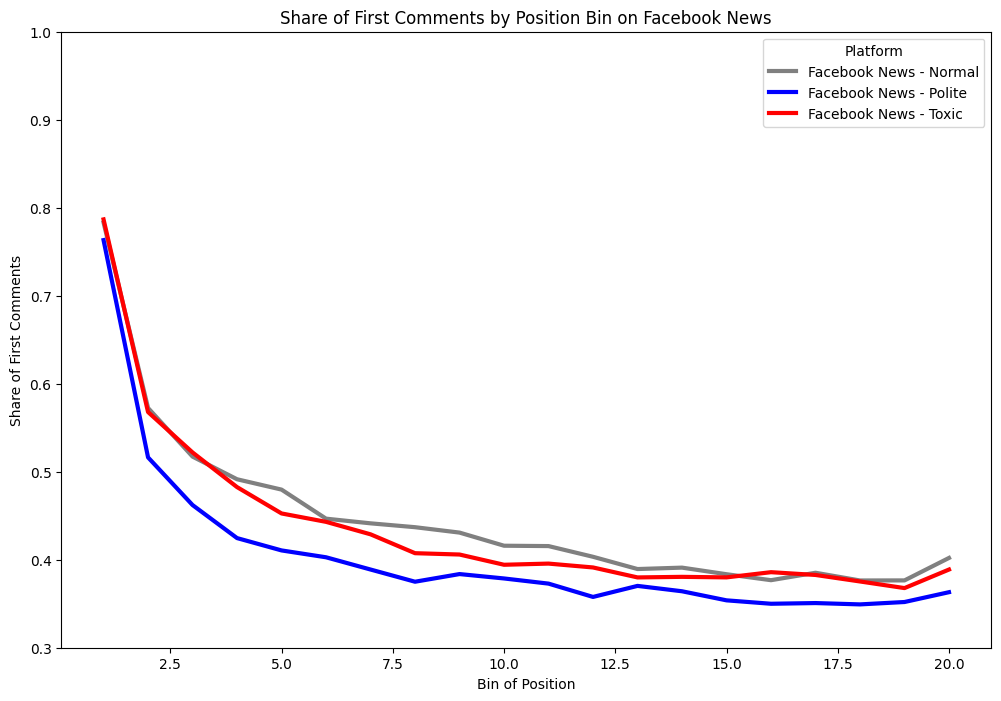

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Assuming politeo_M1, toxico_M1, normalo_M1 are your DataFrames
politeo_M1['Platform'] = 'Facebook News - Polite'
toxico_M1['Platform'] = 'Facebook News - Toxic'
normalo_M1['Platform'] = 'Facebook News - Normal'

# Combine all DataFrames into a single DataFrame
all_data = pd.concat([politeo_M1, toxico_M1, normalo_M1], ignore_index=True)

# Calculate additional features
all_data['number_of_comments'] = all_data.groupby('post_id')['post_id'].transform('count')
all_data['sequential_position'] = all_data.groupby('post_id')['temporal_distance_birth_base_100h'].rank(method='first')
num_bins = 20
all_data['bin_of_position'] = ((all_data['sequential_position'] - 1) / all_data['number_of_comments'] * num_bins).astype(int) + 1
all_data['first_comment'] = all_data['sequential_number_of_comment_by_user_in_thread'] == 1
all_data['first_comment'] = all_data.groupby(['Platform', 'bin_of_position', 'post_id'])['first_comment'].transform('mean')

# Aggregate data across all platforms
agg_activity_obs = all_data.groupby(['Platform', 'bin_of_position'])['first_comment'].mean().reset_index()

# Define color palette
palette = {'Facebook News - Polite': 'blue', 'Facebook News - Toxic': 'red', 'Facebook News - Normal': 'grey'}

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=agg_activity_obs,
    x='bin_of_position',
    y='first_comment',
    hue='Platform',  # Different line for each platform
    estimator='mean',  # or 'sum', 'median', etc. depending on your aggregation preference
    err_style='band',  # Show error band
    errorbar=('ci', 100),  # Confidence interval
    palette=palette,
    linewidth=3
)
plt.title('Share of First Comments by Position Bin on Facebook News')
plt.ylabel('Share of First Comments')
plt.xlabel('Bin of Position')
plt.grid(False)
plt.ylim(0.3, 1)  # Adjust y-axis limits if needed
plt.legend(title='Platform')
plt.show()


5
